In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import quaternionic as qt


# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2 

joblib is not installed. Falling back to sequential computation.


In [2]:
path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
trajs = []
traj = md.load_pdb('./1bna.pdb')
trajs.append(traj)
traj = md.load(path + 'mdtraj_init_traj_file.nc', top=path + 'snapshot-9031ps.pdb')#[:200]
trajs.append(traj)
path  = '/Users/thor/surfdrive/Data/h-ns/BacterialChromatin/FI_simulations/0_k/8_Haff/' #0_3GC'
i =0
traj = md.load(path+f'dry_{i}_run.xtc', top=path+f'dry_{i}_run.pdb',stride=5).remove_solvent()
traj = traj.atom_slice(traj.top.select('not protein'))
traj = traj.superpose(traj,0)
trajs.append(traj)

In [3]:
traj = trajs[1].remove_solvent()
traj = traj.superpose(traj,0)
view = nv.show_mdtraj(traj[3920:4090])
selection = traj.top.select('resid 4 13')
view.clear()
view.add_representation('licorice',selection=selection)
view

NGLWidget(max_frame=169)

In [4]:
nucs_quat, nucs_euler, nucs_so3, nucs_cayley = [], [], [], []
for traj in trajs:
    nucs_quat.append(mdna.NucleicFrames_quaternion(traj, angle=True))
    nucs_euler.append(mdna.NucleicFrames_quaternion(traj, euler=True))
    nucs_so3.append(mdna.NucleicFrames(traj))
    nucs_cayley.append(mdna.NucleicFrames_quaternion(traj, cayley=True))

In [5]:
def make_frame_traj(xyz):
        # Convert vector endpoints into positions relative to the origin for each frame
        new_xyz = np.zeros_like(xyz)
        for i in range(xyz.shape[0]):
            new_xyz[i, 0, :] = xyz[i, 0, :]  # Set the origin
            for j in range(1, 4):
                new_xyz[i, j, :] = xyz[i, 0, :] + xyz[i, j, :]*0.34  # Calculate vector positions

        # Create a topology for the reference frames
        topology = md.Topology()

        # Add a single chain to the topology
        chain = topology.add_chain()

        # Add argon atoms to the topology for visualization
        for i in range(4):
            # All atoms belong to the same residue here, representing a reference frame
            residue = topology.add_residue(name='RefFrame', chain=chain)
            topology.add_atom('Ar' + str(i), element=md.element.argon, residue=residue)

        # Add bonds between the origin and each of the three vectors in each frame
        for i in range(1, 4):  # From 1 to 3, because 0 is the origin
            topology.add_bond(topology.atom(0), topology.atom(i))

        # Create a trajectory from the new xyz coordinates and the topology
        traj = md.Trajectory(new_xyz, topology=topology)
        return traj


traj = trajs[1][3920:4090].remove_solvent()
idx = 5
# traj = trajs[2].remove_solvent()[::10]


nuc = mdna.NucleicFrames_quaternion(traj,euler=True)
frames = nuc.base_frames

frame_a = frames[nuc.res_A[idx]]
frame_b = frames[nuc.res_B[idx]]
frame_b[:,[2,3]] *= -1
traj_a = make_frame_traj(frame_a)
traj_b = make_frame_traj(frame_b)
frame_traj = traj_a.stack(traj_b)
print(frame_traj,traj_a,traj_b)
# new = frame_traj.stack(bases)
total = frame_traj.stack(traj)
selection = total.top.select(f'resid {idx+8} {8+(nuc.n_bp*2)-1-idx}')
view = nv.show_mdtraj(total)
view.clear()
view.add_representation('licorice', color='red',selection=[0,1,2,3])
view.add_representation('licorice', color='blue',selection=[4,5,6,7])
view.add_representation('licorice', color='green',selection=selection)

view

<mdtraj.Trajectory with 170 frames, 8 atoms, 8 residues, without unitcells> <mdtraj.Trajectory with 170 frames, 4 atoms, 4 residues, without unitcells> <mdtraj.Trajectory with 170 frames, 4 atoms, 4 residues, without unitcells>


NGLWidget(max_frame=169)

In [11]:
def plot_test_0(nuc,ax,s=10):
    params,_ = nuc.get_parameters()
    for i in range(12):
        ax[i].plot(params.swapaxes(0,2)[i],'-o',markersize=s)
        ax[i].set_title(_[i])

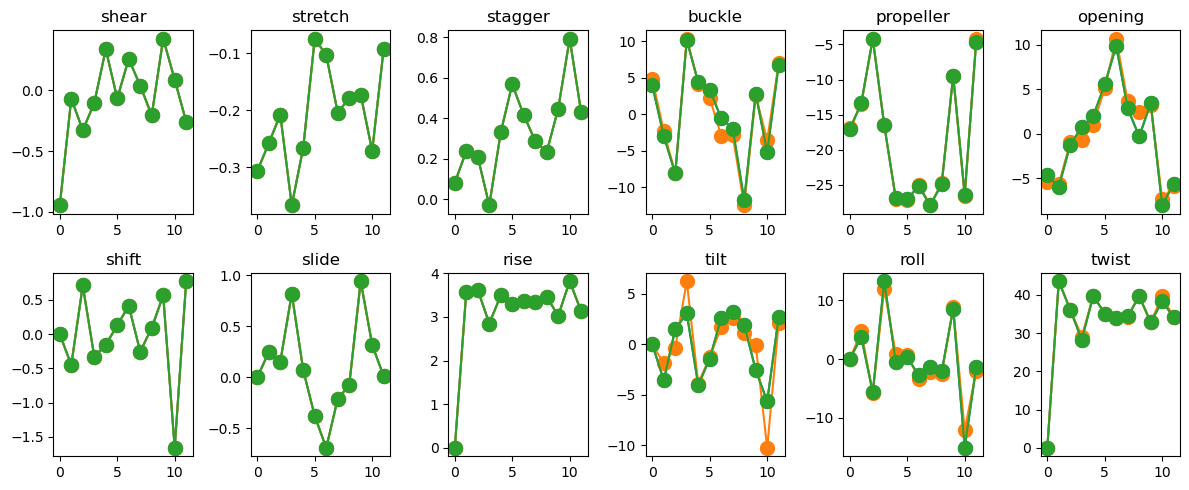

In [13]:
fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=False)
ax = ax.flatten()
plot_test_0(nucs_so3[0],ax,s=10)
plot_test_0(nucs_euler[0],ax)
plot_test_0(nucs_quat[0],ax)
# plot_test_0(nucs_cayley[0],ax)

fig.tight_layout()

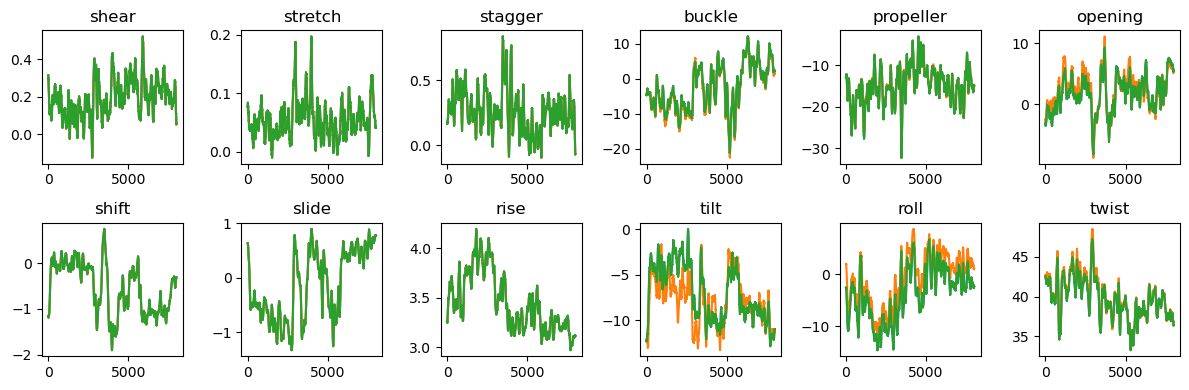

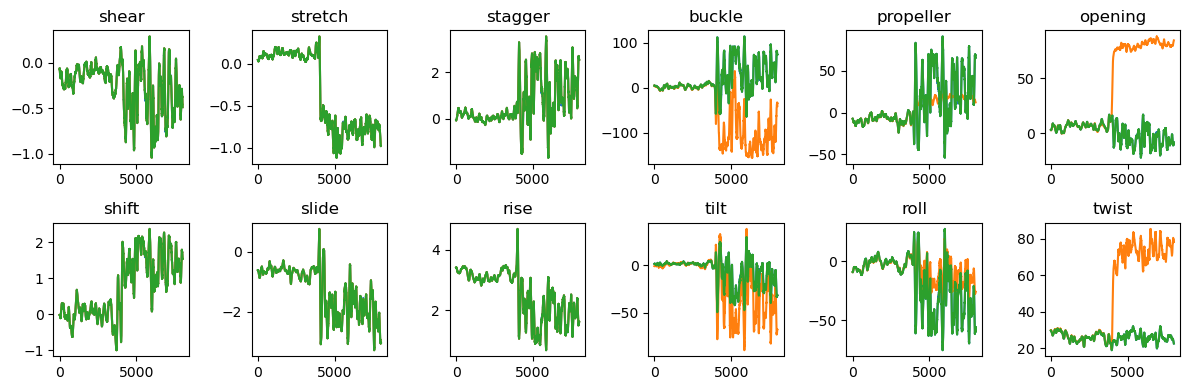

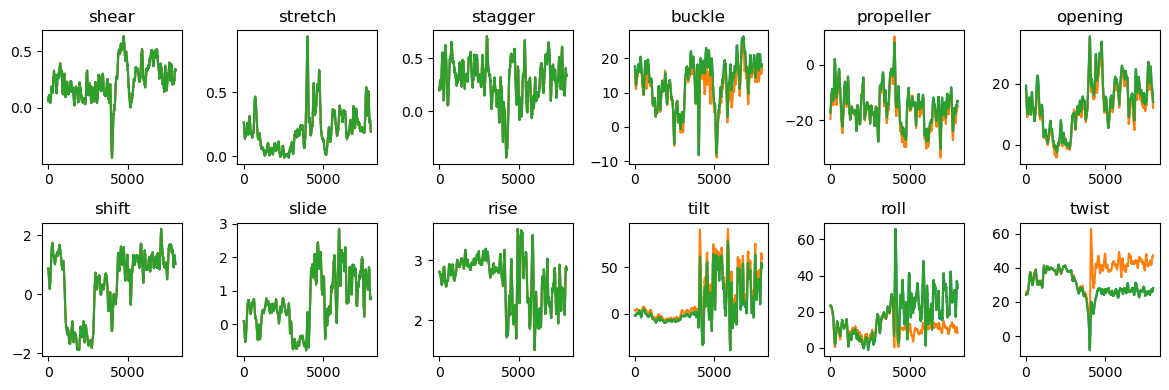

In [14]:
def lpfilter(input_signal, win):
    # Low-pass linear Filter
    # (2*win)+1 is the size of the window that determines the values that influence 
    # the filtered result, centred over the current measurement
    # http://scotthosking.com/notebooks/smooth_timeseries/
    from scipy import ndimage
    kernel = np.lib.pad(np.linspace(1,3,win), (0,win-1), 'reflect') 
    kernel = np.divide(kernel,np.sum(kernel)) # normalise
    output_signal = ndimage.convolve(input_signal, kernel) 
    return output_signal

def plot_test_1(nuc,ax,idx=5):
    params,_ = nuc.get_parameters()
    for i in range(12):
        ax[i].plot(lpfilter(params.swapaxes(0,2)[i][idx].T,50))
        ax[i].set_title(_[i])


fig,ax = plt.subplots(2,6, figsize=[12,4],sharex=False)
ax = ax.flatten()
idx = 3
plot_test_1(nucs_so3[1],ax,idx)
plot_test_1(nucs_euler[1],ax,idx)
plot_test_1(nucs_quat[1],ax,idx)
#plot_test_1(nucs_cayley[1],ax,idx)

fig.tight_layout()

fig,ax = plt.subplots(2,6, figsize=[12,4],sharex=False)
ax = ax.flatten()
idx = 4
plot_test_1(nucs_so3[1],ax,idx)
plot_test_1(nucs_euler[1],ax,idx)
plot_test_1(nucs_quat[1],ax,idx)
#plot_test_1(nucs_cayley[1],ax,idx)

fig.tight_layout()

fig,ax = plt.subplots(2,6, figsize=[12,4],sharex=False)
ax = ax.flatten()
idx = 5
plot_test_1(nucs_so3[1],ax,idx)
plot_test_1(nucs_euler[1],ax,idx)
plot_test_1(nucs_quat[1],ax,idx)
#plot_test_1(nucs_cayley[1],ax,idx)

fig.tight_layout()

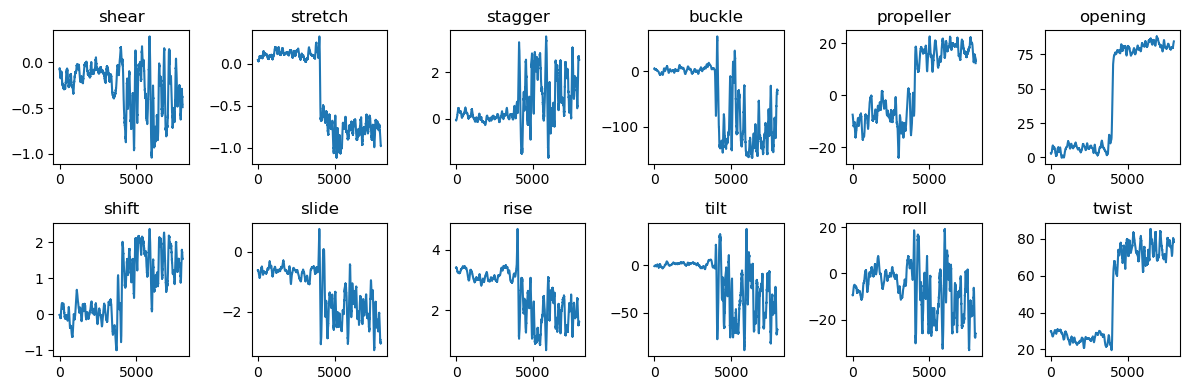

In [15]:
fig,ax = plt.subplots(2,6, figsize=[12,4],sharex=False)
ax = ax.flatten()
idx = 4
plot_test_1(nucs_euler[1],ax,idx)
fig.tight_layout()

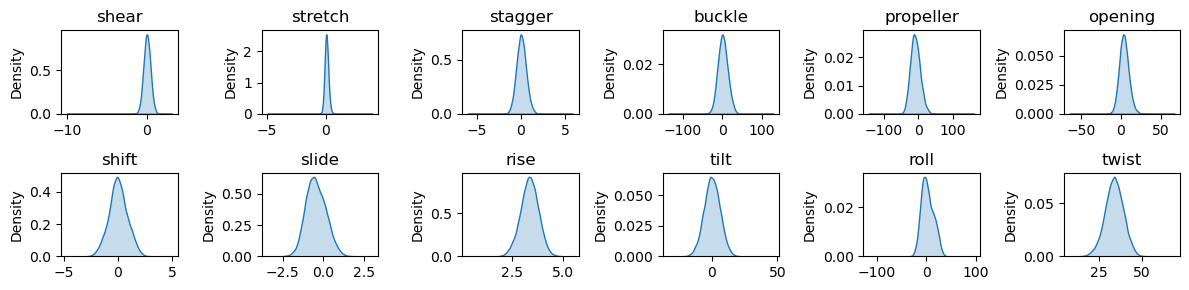

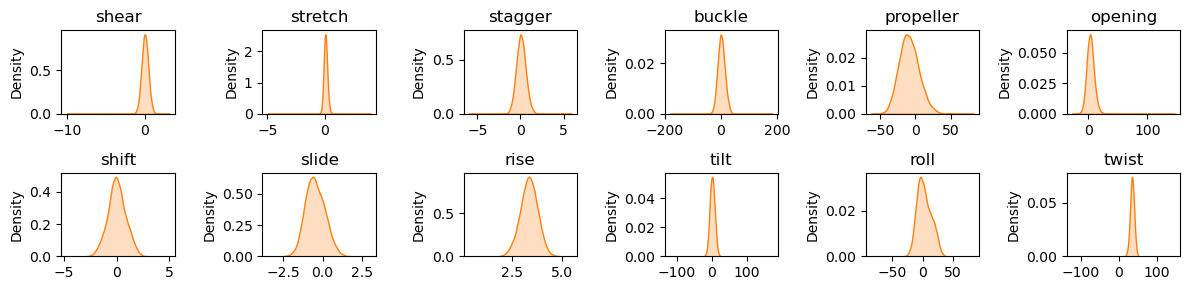

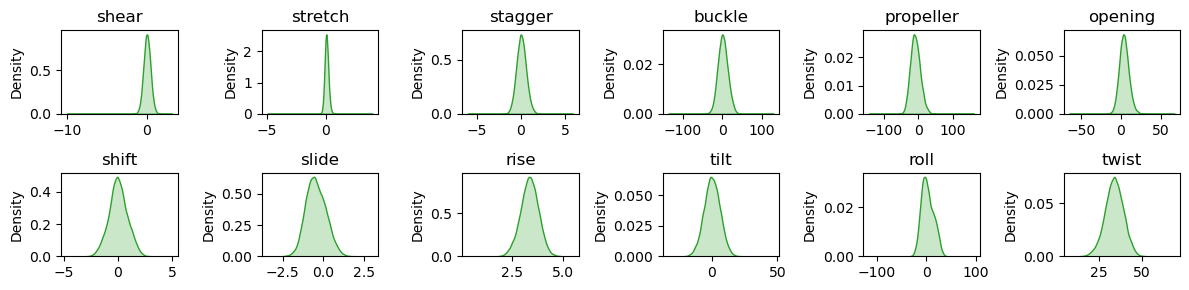

In [16]:
import seaborn as sns
def plot_test_2(nuc,ax,color='blue'):
    params,_ = nuc.get_parameters()
    for i in range(12):
        if i < 5:
            sns.kdeplot(params.swapaxes(0,2)[i].flatten(),ax=ax[i],fill=True,color=color)
        else:
            # skip empty first base pair step 
            sns.kdeplot(params.swapaxes(0,2)[i][1:].flatten(),ax=ax[i],fill=True,color=color)
        ax[i].set_title(_[i])


fig,ax = plt.subplots(2,6, figsize=[12,3],sharex=False)
ax = ax.flatten()
plot_test_2(nucs_so3[2],ax,color='tab:blue')
fig.tight_layout()

fig,ax = plt.subplots(2,6, figsize=[12,3],sharex=False)
ax = ax.flatten()
plot_test_2(nucs_euler[2],ax,color='tab:orange')
fig.tight_layout()

fig,ax = plt.subplots(2,6, figsize=[12,3],sharex=False)
ax = ax.flatten()
plot_test_2(nucs_quat[2],ax,color='tab:green')
fig.tight_layout()


# fig,ax = plt.subplots(2,6, figsize=[12,3],sharex=False)
# ax = ax.flatten()

# plot_test_2(nucs_cayley[2],ax,color='tab:red')

# fig.tight_layout()

In [17]:
traj = trajs[2][::2].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
angles = np.array(nuc.angles)
traj, angles.shape

(<mdtraj.Trajectory with 2001 frames, 762 atoms, 24 residues, and unitcells at 0x28beba5a0>,
 (0,))

In [ ]:
for idx in range(nuc.n_bp):
    q0 = nuc.quat[idx-1]
    q1 = nuc.quat[idx]
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
    mask = dot < 0
    q0[mask] = -q0[mask]



In [ ]:
traj = trajs[0][::1].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
traj

In [ ]:
traj = trajs[0][::1].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)

R = []
for idx in range(1,nuc.n_bp):
    q0 = nuc.quat[idx-1]
    q1 = nuc.quat[idx]
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
    print(dot)
    # if dot negative
    if dot < 0.0:
        A = -q1.inverse*q0
        q_mid = qt.slerp(-q0,q1,0.5)
    else:
        A = q1.inverse*q0
        q_mid = qt.slerp(q0,q1,0.5)
        
    R.append(A.to_axis_angle)
    
R = np.array(R).T
# R_ = np.array(R_).T
# R.shape, R_.shape
plt.plot(np.rad2deg(R[2].T))
# plt.plot(np.rad2deg(R_[-1].T))
# plt.ylim(-10,50)

In [ ]:
traj = trajs[2][::1].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)


In [ ]:
quaterions_A  = nuc.quat[0]
quaterions_B  = nuc.quat[1]
dot = (quaterions_A.w*quaterions_B.w) + (quaterions_A.x*quaterions_B.x) + (quaterions_A.y*quaterions_B.y) + (quaterions_A.z*quaterions_B.z)
mask = dot < 0



Here we are getting somewhere

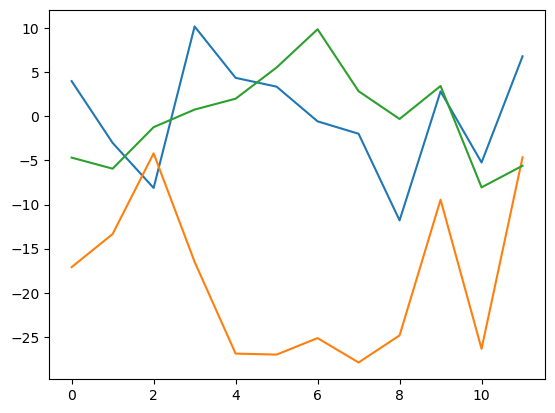

In [21]:
traj = trajs[0][::1].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
check = True
R = []
q_mids = []
for idx in range(0,nuc.n_bp):
    q0 = nuc.quats_A[idx]
    q1 = nuc.quats_B[idx]
    #print(q0.w, q1.w)
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)

    # if dot negative
    if dot < 0.0:
        q0 = -q0
        A = q1.inverse*q0
        q_mid = qt.slerp(q0,q1,0.5)
    else:
        A = q1.inverse*q0
        q_mid = qt.slerp(q0,q1,0.5)
        
    if not check:
        A = q0.inverse*q1
    R.append(A.to_axis_angle)

R = np.array(R).T

fig,ax = plt.subplots()
ax.plot(np.rad2deg(R[0].T))
ax.plot(np.rad2deg(R[1].T))
ax.plot(np.rad2deg(R[2].T))

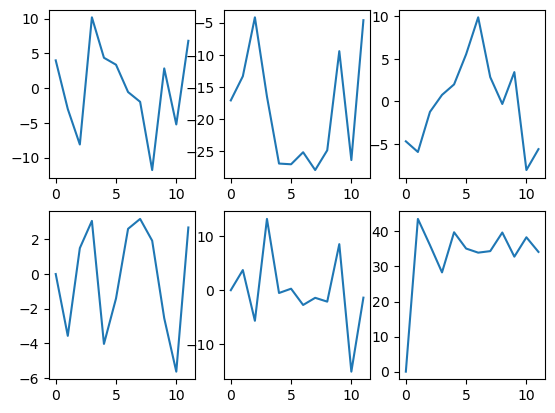

In [23]:
traj = trajs[0][::1].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
check = True
R = []
q_mids = []
for idx in range(0,nuc.n_bp):
    q0 = nuc.quats_A[idx]
    q1 = nuc.quats_B[idx]
    #print(q0.w, q1.w)
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)

    # # if dot negative
    # if dot < 0.0:
    #     A = -q1.inverse*q0
    #     q_mid = qt.slerp(-q0,q1,0.5)
    # else:
    #     A = q1.inverse*q0
    #     q_mid = qt.slerp(q0,q1,0.5)
    mask = dot < 0.0
    q0[mask] = -q0[mask]
    if check:
        A = q1.inverse*q0
        q_mid = qt.slerp(q0,q1,0.5)
    else:
        A = q1.inverse*q0
        q_mid = qt.slerp(q0,q1,0.5)

    R.append(A.to_axis_angle)
    q_mids.append(q_mid)

R_ = np.zeros((nuc.n_bp,3))
for idx in range(1, nuc.n_bp):
    q0 = q_mids[idx-1]
    q1 = q_mids[idx]
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
    mask = dot < 0.0
    q0[mask] = -q0[mask]
    if check:
        A = q0.inverse*q1
    else:
        A = q0.inverse*q1


    # if dot < 0.0:
    #     A = -q0.inverse*q1
    # else:
    #     A = q0.inverse*q1

    # if not check:
    #     A = q0.inverse*q1
    R_[idx] = A.to_axis_angle


R = np.array(R).T

# add empty first bp step
R_ = np.array(R_).T



fig,ax = plt.subplots(2,3)
ax = ax.flatten()
ax[0].plot(np.rad2deg(R[0].T))
ax[1].plot(np.rad2deg(R[1].T))
ax[2].plot(np.rad2deg(R[2].T))

ax[3].plot(np.rad2deg(R_[0].T))
ax[4].plot(np.rad2deg(R_[1].T))
ax[5].plot(np.rad2deg(R_[2].T))

In [24]:
def robust_to_axis_angle(q):
    # Ensure quaternion is of type quaternionic
    # q = qt.array(quat)
    # Calculate angle
    angle = 2 * np.arccos(q.w)
    
    # Handle the special case near 180 degrees
    threshold = 0.00  # Threshold near 180 degrees (in radians)
    near_180 = np.isclose(angle, np.pi, atol=threshold)

    axis = np.empty(q.shape[:-1] + (3,))
    axis[~near_180] = 2 * np.log(q[~near_180].normalized).vector
    
    # When near 180 degrees, use a different computation for axis
    axis[near_180] = q[near_180].vector
    axis[near_180] /= np.linalg.norm(axis[near_180], axis=-1, keepdims=True)
    axis = 2 * np.log(q.normalized).vector  
    # Combine the axis and angle
    # axis_angle = axis * angle[..., np.newaxis]
    return axis

R = robust_to_axis_angle(A)


import numpy as np

def robust_to_axis_angle(q):

    angle = 2 * np.arccos(q.w)
    
    # Axis calculation: normalized vector part
    # Safe normalization, adding small epsilon to avoid division by zero
    epsilon = 1e-6
    norms = np.linalg.norm(q.vector, axis=-1, keepdims=True) + epsilon
    axis = q.vector / norms
    
    # Special handling for exactly 180 degrees
    # At exactly 180 degrees, cos(theta) = -1 (w = -1), thus arccos(-1) = pi
    print(angle)
    is_180_degrees = np.isclose(angle, np.pi,rtol=1e-5,atol=1e-5)
    print(np.sum(is_180_degrees))
    if np.any(is_180_degrees):
        axis[is_180_degrees] = q[is_180_degrees].vector
        norms_180 = np.linalg.norm(axis[is_180_degrees], axis=-1, keepdims=True) + epsilon
        axis[is_180_degrees] = axis[is_180_degrees] / norms_180
    
    # Combine the axis and angle
    axis_angle = axis * angle[..., np.newaxis]
    return axis_angle

# # Example usage:
# quaternions = np.array([...])  # Your quaternion data
# axis_angles = robust_to_axis_angle(quaternions)


9
0 amask 1071
[0.26903617 0.23866114 0.11211072 ... 0.26031017 0.12826871 0.34589642]
0
1 amask 702
[0.23956878 0.28855507 0.35696945 ... 0.26092853 0.27689631 0.27652762]
0
2 amask 0
[0.37343725 0.34707431 0.35002191 ... 0.25964461 0.23763091 0.38213174]
0
3 amask 0
[0.35070757 0.35005915 0.60508735 ... 0.56763731 0.06981842 0.29516589]
0
4 amask 1297
[0.2787629  0.43960305 0.23256308 ... 2.72238711 3.12928882 3.13213853]
0
5 amask 0
[0.73637598 0.56895446 0.59648045 ... 0.49606472 0.67734342 0.71461411]
0
6 amask 0
[0.41187316 0.3626352  0.20851763 ... 0.17480072 0.26633657 0.10946927]
0
7 amask 0
[0.46086226 0.45153547 0.19499208 ... 0.24159414 0.39639668 0.11317496]
0
8 amask 467
[0.54255562 0.25628539 0.42057775 ... 0.44975027 0.66566031 1.01268771]
0
(3, 8000, 9)


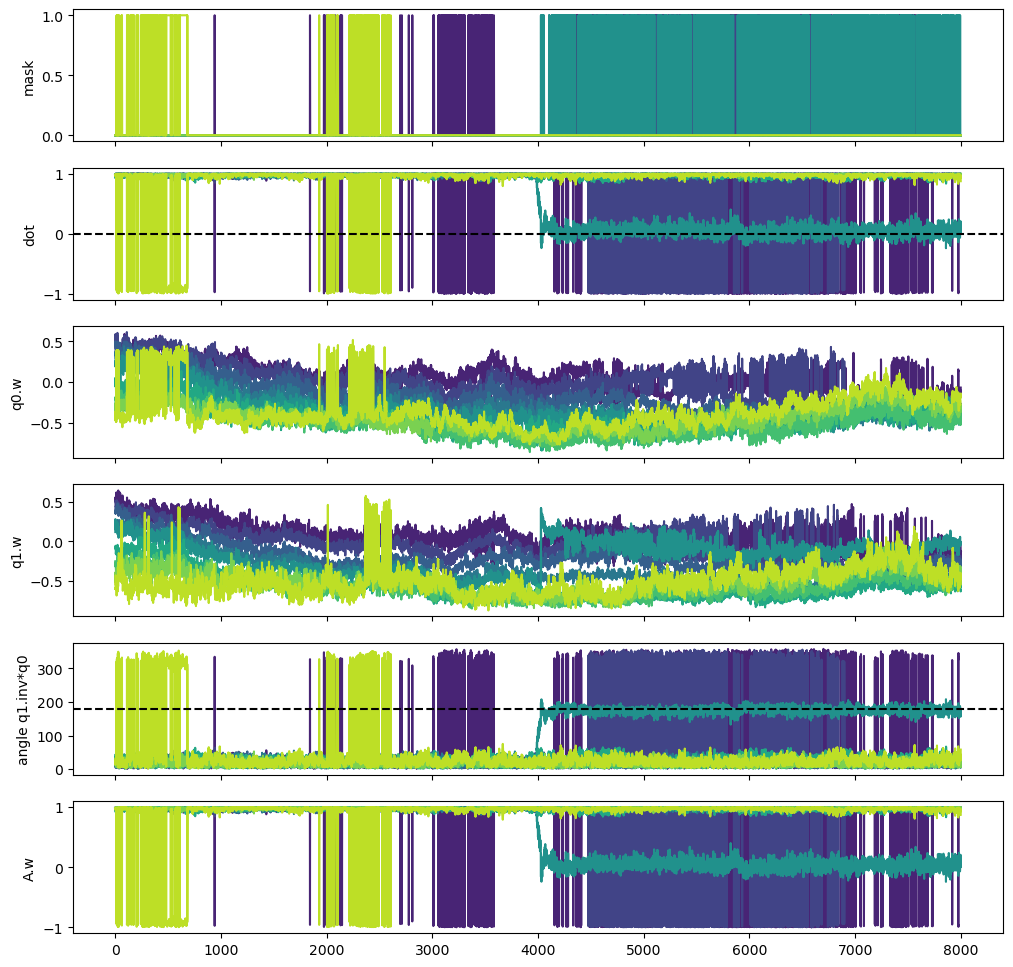

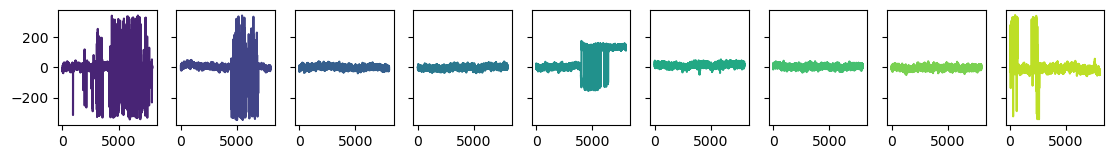

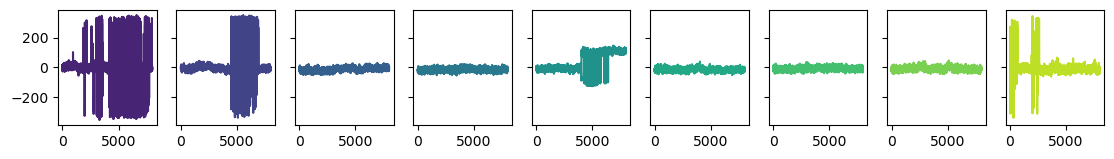

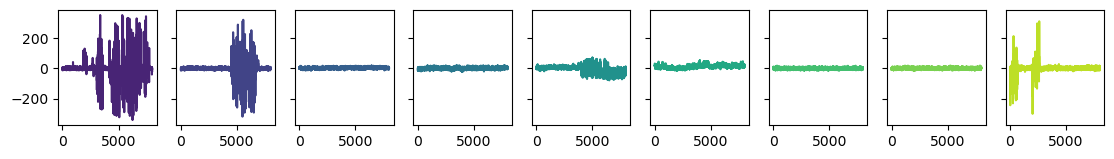

In [27]:
check = False
traj = trajs[1][::1].remove_solvent()
#nuc = mdna.NucleicFrames_quaternion(traj.atom_slice(traj.top.select('resid 0 1 18 17')), euler=True)
#nuc = mdna.NucleicFrames_quaternion(traj.atom_slice(traj.top.select('resid 3 16 4 15')), euler=True)
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
print(nuc.n_bp)
colors = sns.color_palette('viridis',nuc.n_bp)
fig, ax = plt.subplots(6,1,sharex=True, figsize=[12,12])
ax[0].set_ylabel('mask')
ax[1].set_ylabel('dot')
ax[2].set_ylabel('q0.w')
ax[3].set_ylabel('q1.w')
ax[4].set_ylabel('angle q1.inv*q0')
ax[5].set_ylabel('A.w')
R = []
R_mid = []
for idx in range(0,nuc.n_bp):
    q0 = nuc.quats_A[idx]
    q1 = nuc.quats_B[idx]
    
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
    mask = dot < 0.0
    ax[0].plot(mask, color=colors[idx]) 
    ax[1].plot(dot, color=colors[idx])
    ax[2].plot(q0.w, color=colors[idx])
    ax[3].plot(q1.w, color=colors[idx])
    if check:
        q0[mask] = -q0[mask]

    # if dot < 0.0:
    #     A = -q1.inverse*q0
    #     q_mid = qt.slerp(-q0,q1,0.5)
    # else:
    #     A = q1.inverse*q0
    #     q_mid = qt.slerp(q0,q1,0.5)

    #q1 = qt.array([[-1*q.w, q.x, q.y, q.z ]if m else q for m,q in zip(mask,q1)])
  
    A = q1.inverse*q0
    #A = qt.array([[-1*q.w, q.x, q.y, q.z ]if m else q for m,q in zip(mask,A)])
    angle = 2 * np.arccos(A.w)
    
    a_mask = np.rad2deg(angle) > 179.9
    print(idx,'amask',np.sum(a_mask))   
    ax[4].plot(np.rad2deg(angle), color=colors[idx])
    ax[5].plot(A.w, color=colors[idx])
  
    
    # heading = np.arctan2(2*A.y*A.w-2*A.x*A.z , 1 - 2*A.y**2 - 2*A.z**2)
    # attitude = np.arcsin(2*A.x*A.y + 2*A.z*A.w)
    # bank = np.arctan2(2*A.x*A.w-2*A.y*A.z , 1 - 2*A.x**2 - 2*A.z**2)

    # # pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
    # # yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
    # # roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)

    # #pitch = np.arcsin(2*A.x*A.y + 2*A.z*A.w) # attitude definition 
    

    # pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
    # # yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
    # # roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)
    # # # 
    # # # Initialize yaw and roll with default values that will apply when no specific condition is met
    # yaw = np.zeros_like(pitch)
    # roll = np.zeros_like(pitch)

    # # Condition for pitch = pi/2
    # mask_pi_2 = pitch == np.pi/2
    # yaw[mask_pi_2] = -np.arctan2(A.x[mask_pi_2],A.w[mask_pi_2])
    # roll[mask_pi_2] = 0.0

    # # Condition for pitch = -pi/2
    # mask_neg_pi_2 = pitch == -np.pi/2
    # yaw[mask_neg_pi_2] = np.arctan2(A.x[mask_neg_pi_2],A.w[mask_neg_pi_2])
    # roll[mask_neg_pi_2] = 0.0

    # # Default condition (where neither pi/2 nor -pi/2 conditions are met)
    # mask_else = ~(mask_pi_2 | mask_neg_pi_2)
    # yaw[mask_else] = np.arctan2(2.0*(A.y[mask_else]*A.z[mask_else] + A.w[mask_else]*A.x[mask_else]),
    #                             A.w[mask_else]**2 - A.x[mask_else]**2 - A.y[mask_else]**2 + A.z[mask_else]**2)
    # roll[mask_else] = np.arctan2(2.0*(A.x[mask_else]*A.y[mask_else] + A.w[mask_else]*A.z[mask_else]),
    #                             A.w[mask_else]**2 + A.x[mask_else]**2 - A.y[mask_else]**2 - A.z[mask_else]**2)

    # R.append(np.vstack((yaw, pitch, roll)).swapaxes(0,1))
    #R.append(np.vstack((heading, attitude, bank)).swapaxes(0,1))
    #R.append(A.to_axis_angle) 
    R.append(robust_to_axis_angle(A))

ax[4].axhline(180, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')

R = np.array(R).swapaxes(0,2)
print(R.shape)
dist = False
fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[0].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[0].T[i]),color=colors[i])

fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[1].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[1].T[i]),color=colors[i])

fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[2].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[2].T[i]),color=colors[i])



In [ ]:
np.rad2deg(np.pi)

In [ ]:
plt.plot(R[0][:,-1])
plt.plot((R[0][:,-1]-np.pi)%(np.pi))


In [ ]:
print(mask)

In [ ]:
traj = trajs[1][3500:4500].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
traj

In [ ]:
idx = 5
frames =  nuc.base_frames
frame_a = frames[nuc.res_A[idx]]
frame_b = frames[nuc.res_B[idx]]
time = range(frame_a.shape[0])
q0 = nuc.quats_A[idx]
q1 = nuc.quats_B[idx]

q0 = q0.to_minimal_rotation(time,iterations=100) 
q1 = q1.to_minimal_rotation(time,iterations=100)
q0 = qt.unflip_rotors(q0)
q1 = qt.unflip_rotors(q1)
A = q1.inverse*q0
Omega = A.to_axis_angle
#plt.plot(np.rad2deg(Omega))
plt.plot(q0.w)
plt.plot(q1.w)


In [ ]:
traj = trajs[2].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)
idx = 4
frames =  nuc.base_frames
frame_a = frames[nuc.res_A[idx]]
frame_b = frames[nuc.res_B[idx]]
frame_a.shape, frame_b.shape

In [ ]:
plt.plot(frame_a[:,1,:])

In [ ]:
traj = trajs[2][3500:4500].remove_solvent()
nuc = mdna.NucleicFrames_quaternion(traj, euler=True)

In [ ]:

fig,ax=plt.subplots()
idx = 4
frames =  nuc.base_frames
frame_a = frames[nuc.res_A[idx]]
frame_b = frames[nuc.res_B[idx]]

q0 = nuc.quats_A[idx]
# q1 = nuc.quats_B[idx]
q1 = qt.array.from_rotation_matrix(frame_a)
# q0 = qt.unflip_rotors(q0)
q1 = q1.to_minimal_rotation(range(frame_a.shape[0]),iterations=100)

#q1 = qt.array.from_rotation_matrix(frame_b)
# q1 = qt.unflip_rotors(q1)
# q1 = q1.to_minimal_rotation(range(frame_b.shape[0]))

Omega = A.to_axis_angle
# ax.plot(q1.w)
# ax.axhline(0)
# ax.axhline(1)
# ax.axhline(-1)
# np.diff([idx[0] for idx in np.argwhere(q1.w>0)])
plt.plot(q0.w)
plt.plot(q1.w)
#sns.kdeplot(np.rad2deg(Omega),ax=ax)
#plt.plot(np.rad2deg(A.w))
#sns.kdeplot(A.w)
# sns.kdeplot(x=q0.w,y=q1.w)
# sns.kdeplot(


# idx = 7
# q0 = nuc.quat[idx+1]
# q1 = nuc.quat[idx]
# A = q1.inverse*q0
# Omega = A.to_axis_angle
# fig,ax=plt.subplots()
# sns.kdeplot(np.rad2deg(Omega))


In [ ]:

R, R_ = [], []
frames =  nuc.base_frames
#for idx in range(nuc.n_bp):
fig, ax = plt.subplots(2,1)
for idx in range(4,5):

    frame_a = frames[nuc.res_A[idx]]
    frame_b = frames[nuc.res_B[idx]]
    
    q0 = nuc.quats_A[idx]
    q1 = nuc.quats_B[idx]

    print(q0.shape, q1.shape, frame_a.shape, frame_b.shape)
    ax[0].plot(q0.w) 
    ax[1].plot(q1.w)

    

#     q1 = nuc.quat[idx]
#     A = q0.inverse*q1
#     A_= q0.inverse*-q1
#     R.append(A.to_axis_angle)
#     R_.append(A_.to_axis_angle)

# R = np.array(R).T
# R_ = np.array(R_).T
# R.shape, R_.shape
# plt.plot(np.rad2deg(R[-1].T))
# plt.plot(np.rad2deg(R_[-1].T))
# plt.ylim(0,90)

In [ ]:
fig, ax = plt.subplots()
ax.plot(q0.w[500:550])
ax.plot(q1.w[500:550])

In [ ]:
import quaternionic as qt
fig, ax = plt.subplots(int(np.ceil(nuc.n_bp/2)),2, figsize=[12,5],sharex=True)
ax = ax.flatten()
for _,q in enumerate(nuc.quat):
    #ax[_].plot(q.w,alpha=0.85)
    #ax[_].plot(qt.unflip_rotors(q,inplace=False).w,'--',alpha=0.85)
    angle = np.arccos(q.w)*2 
    unflip_angle = np.arccos(qt.unflip_rotors(q,inplace=False).w)*2
    ax[_].plot(angle,alpha=0.85)
    ax[_].axhline(0,c='k')
    ax[_].axhline(np.pi,c='k')
    ax[_].axhline(np.pi*2,c='k')
    # ax[_].plot(unflip_angle,'--',alpha=0.85)

In [ ]:
import quaternionic as qt
fig, ax = plt.subplots(int(np.ceil(nuc.n_bp/2)),2, figsize=[12,5],sharex=True)
ax = ax.flatten()
for _,(a,b) in enumerate(zip(nuc.quats_A,nuc.quats_B)):
    #ax[_].plot(q.w,alpha=0.85)
    #ax[_].plot(qt.unflip_rotors(q,inplace=False).w,'--',alpha=0.85)
    angle_a = np.arccos(a.w)*2 
    angle_b = np.arccos(b.w)*2

    #unflip_angle = np.arccos(qt.unflip_rotors(q,inplace=False).w)*2
    # ax[_].plot(a.w,alpha=0.85)
    # ax[_].plot(b.w,alpha=0.85)
    ax[_].plot(angle_a,alpha=0.85)
    ax[_].plot(angle_b,alpha=0.85)
    # ax[_].axhline(0,c='k')
    # ax[_].axhline(np.pi,c='k')
    # ax[_].axhline(np.pi*2,c='k')
    # ax[_].plot(unflip_angle,'--',alpha=0.85)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[12,5])
_ = ax[0].plot(angles[:12].T)
_ = ax[1].plot(angles[12:].T)

In [ ]:
# path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
# traj = md.load_pdb('./1bna.pdb')

euler = True
#nuc = mdna.NucleicFrames(traj)#,euler=euler)
nuc = mdna.NucleicFrames_quaternion(traj[:10],euler=euler)
params, names = nuc.get_parameters()
print(names, params.shape)
# pair, _ = nuc.get_parameters(pair=True)
# print(_, pair.shape)
# step, _ = nuc.get_parameters(step=True)
# print(_, step.shape)
params.shape

In [ ]:
(201, 12, 12)

In [ ]:
view = nv.show_mdtraj(traj, gui=True)
view.clear()
view.add_representation('licorice')
view 

In [ ]:
# fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=True)
# ax = ax.flatten()
# for i in range(12):
#     ax[i].plot(params.swapaxes(0,2)[i].T)
#     ax[i].set_title(names[i])

# fig.tight_layout()

In [ ]:
dist = True
fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=False)
ax = ax.flatten()
for i in range(12):
    if dist:
        ax[i].hist(params.swapaxes(0,2)[i].flatten(), bins=40,density=True, fill=True)
    else:
        ax[i].plot(params.swapaxes(0,2)[i].T)
    ax[i].set_title(names[i])

fig.tight_layout()

In [ ]:
dist = True
fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=False)
ax = ax.flatten()
for i in range(12):
    if dist:
        ax[i].hist(params.swapaxes(0,2)[i].flatten(), bins=40,density=True, fill=True)
    else:
        ax[i].plot(params.swapaxes(0,2)[i].T)
    ax[i].set_title(names[i])

fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=False)
ax = ax.flatten()
for i in range(12):
    ax[i].plot(params.swapaxes(0,2)[i].T)
    ax[i].set_title(names[i])

fig.tight_layout()

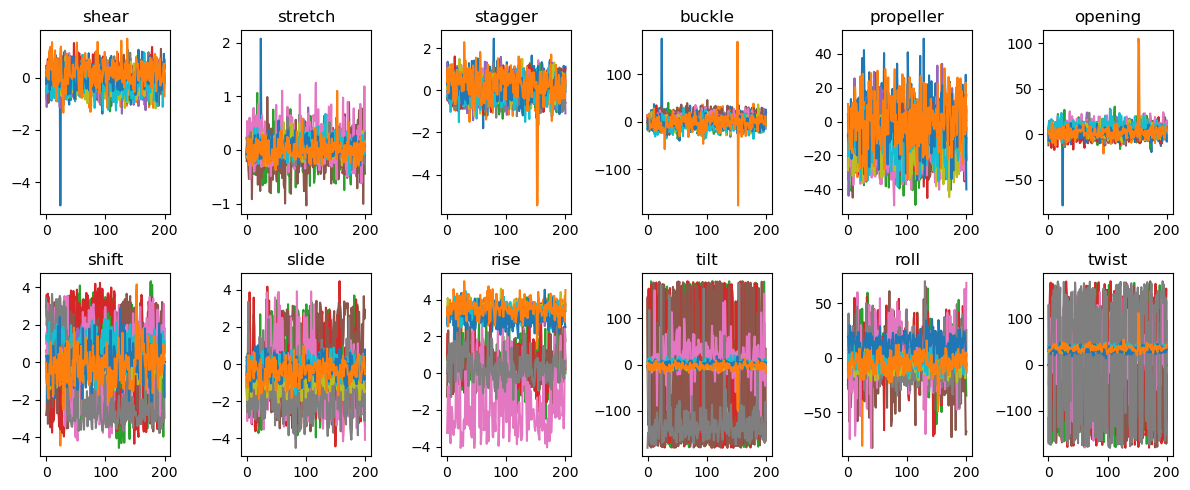

In [ ]:
fig,ax = plt.subplots(2,6, figsize=[12,5],sharex=False)
ax = ax.flatten()
for i in range(12):
    ax[i].plot(params.swapaxes(0,2)[i].T)
    ax[i].set_title(names[i])

fig.tight_layout()

In [ ]:
nuc.quat.shape

In [ ]:

pair, step = nuc.pair_parameters, nuc.step_parameters   
print(pair.shape , step.shape)


fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
ax = ax.flatten()
for _, param in enumerate(pair.swapaxes(0,2)):
    print(param.shape)
    ax[_].plot(param[0])#,axis=1))
fig.tight_layout()

fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):

    print(param.shape)
    ax[_].plot(param[0])#,axis=1))
fig.tight_layout()

In [ ]:
dist = False
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(pair.swapaxes(0,2)):
    print(param.shape)
    for p in param.T:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    for p in param.T[1:]:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

In [ ]:
dist = False
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(pair.swapaxes(0,2)):
    print(param.shape)
    for p in param.T:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    for p in param.T[1:]:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

In [ ]:
dist = False
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(pair.swapaxes(0,2)):
    print(param.shape)
    for p in param.T:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    for p in param.T[1:]:
        if dist:
            ax[_].hist(p,bins=40,density=True)#,axis=1))    
        else:
            ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(pair.swapaxes(0,2)):
    print(param.shape)
    for p in param.T:
        #ax[_].hist(p,bins=40,density=True)#,axis=1))    
        ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    for p in param.T[1:]:
        #ax[_].hist(p,bins=40,density=True)#,axis=1))    
        ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

In [ ]:
# fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
# ax = ax.flatten()
# for _, param in enumerate(pair.swapaxes(0,2)):
#     print(param.shape)
#     ax[_].plot(param.T[0])#,axis=1))
# fig.tight_layout()
# fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
# ax = ax.flatten()
# for _, param in enumerate(step.swapaxes(0,2)):
#     print(param.shape)
#     ax[_].plot(param.T[0])#,axis=1))
# fig.tight_layout()

# fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
# ax = ax.flatten()
# for _, param in enumerate(pair.swapaxes(0,2)):
#     print(param.shape)
#     for p in param:
#         #ax[_].hist(p,bins=40,density=True)#,axis=1))    
#         ax[_].plot(p)
# #ax[_].hist(param.T,bins=20)#,axis=1))
# fig.tight_layout()

# fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
# ax = ax.flatten()
# for _, param in enumerate(step.swapaxes(0,2)):
#     print(param.shape)
#     for p in param:
#         #ax[_].hist(p,bins=40,density=True)#,axis=1))    
#         ax[_].plot(p)
# #ax[_].hist(param.T,bins=20)#,axis=1))
# fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=False)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    for p in param:
        #ax[_].hist(p,bins=40,density=True)#,axis=1))    
        ax[_].plot(p)
#ax[_].hist(param.T,bins=20)#,axis=1))
fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
ax = ax.flatten()
for _, param in enumerate(step.swapaxes(0,2)):
    print(param.shape)
    ax[_].plot(param.T[0])#,axis=1))
fig.tight_layout()

In [ ]:
nuc.traj.n_frames-1*(nuc.n_bp)

In [ ]:
step.reshape(-1,nuc.n_bp-1,6)

In [ ]:
nuc.traj.n_frames,nuc.n_bp-1, nuc.traj.n_frames*nuc.n_bp-1

In [ ]:
8000*8

In [ ]:
pair.shape, step.shape, nuc.traj.n_frames-1, nuc.n_bp, 6, nuc.traj.n_frames*nuc.n_bp-1

In [ ]:
nuc.trans_step.shape, nuc.quat_step.shape

In [ ]:
nuc.n_bp, nuc.traj.n_frames

In [ ]:
nuc.step_parameters.reshape(nuc.traj.n_frames-1, nuc.n_bp, 6)

In [ ]:
9*8000

In [ ]:
trans_step = nuc.trans_step
quat_step = nuc.quat_step
trans_step.shape, quat_step.shape   

In [ ]:
traj.n_frames*  len(nuc.res_A)

In [ ]:
rigid.reshape(traj.n_frames, len(nuc.res_A), 6)

In [ ]:
quat.rotate([0,-1,-1])

In [ ]:
%%time
nuc.process_base_frames(nuc.res_A)

In [ ]:
nuc = mdna.NucleicFrames_quaternion(traj)
nuc.process_base_frames(nuc.res_A)

In [ ]:
euler = True

traj = md.load_pdb('./1bna.pdb')


nuc = mdna.NucleicFrames_quaternion(traj)
base_frames = nuc.get_base_reference_frames()
nuc.sequence_list

# Get the base pair frames for the A and B chains
frames_a = [nuc.base_frames[res] for res in nuc.res_A]
frames_b = [nuc.base_frames[res] for res in nuc.res_B] 


In [ ]:
euler = True

traj = md.load_pdb('./1bna.pdb')


nuc = mdna.NucleicFrames_quaternion(traj)
base_frames = nuc.get_base_reference_frames()
nuc.sequence_list

# Get the base pair frames for the A and B chains
frames_a = [nuc.base_frames[res] for res in nuc.res_A]
frames_b = [nuc.base_frames[res] for res in nuc.res_B] 

# Get the step frames and base parameters
step_frames, base_parameters = [], []
for frame_a,frame_b in zip(frames_a, frames_b):

    # flip (connecting the backbones) and the (baseplane normals) (2,3)  vector b_L, b_N
    frame_b[:,[2,3]] *= -1

    # get the rigid body parameters and mid/halfway transformation
    rigid_base, mid_orientation = get_rigid_parameters(frame_a, frame_b, step=False, euler=euler)
    step_frames.append(mid_orientation)
    base_parameters.append(rigid_base)


# Get the base step parameters
step_parameters = []
for basestep in range(1,len(step_frames)):
    
    # Get the base step frames in a staggered fashion
    step_frame_a = step_frames[basestep-1]
    step_frame_b = step_frames[basestep]

    # get the rigid body parameters and mid/halfway transformation switch order of the frames
    rigid_step, _ = get_rigid_parameters(step_frame_b, step_frame_a, step=True, euler=euler)
    step_parameters.append(rigid_step)


base_params = np.array(base_parameters)
step_params = np.array(step_parameters)

# Concatenate a zero row to the step parameters
extra_column = np.zeros((1, step_params.shape[1], step_params.shape[2]))

# Concatenating the existing array and the extra column along the first axis
step_params = np.concatenate((extra_column,step_params), axis=0)

params = np.concatenate((base_params, step_params), axis=2).swapaxes(0,2)

step_parameter_names = ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
base_parameter_names = ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
names = base_parameter_names + step_parameter_names


fig,ax = plt.subplots(2,6, figsize=[10,3],sharex=True)
ax = ax.flatten()
for _,param in enumerate(params):
    ax[_].plot(param[0],'-o')
    ax[_].set_title(names[_])

fig.tight_layout()

In [ ]:
# get base pairs
# convert reference frames to quaternion


In [ ]:


def convert_base_pair(frame): 
    """Convert a base pair frame to a translation and quaternion representation.
    Args:
        frame: a 4x4 matrix representing the base pair frame where the rotations are stored row wise
    
        Unflips the quaternion if necessary when dealing with time series data. 
    
    returns: a tuple of (translations, quaternion)"""

    # Get the translation and rotation from the base pair frame
    translations =  frame[:,0]  # extract translations
    rotation = frame[:,1:].transpose(0, 2, 1) # extract rotation matrices as column vectors

    # Convert the rotation matrices to quaternions
    quaternion = qt.array.from_rotation_matrix(rotation)

    # Check if the quaternion needs to be unflipped when dealing with time series
    if quaternion.shape[0] > 1:
        quaternion = qt.unflip_rotors(quaternion)

    # Return the translation and quaternion
    return translations, quaternion

def convert_base_step(orietation):
    """Convert a base pair frame to a translation and quaternion representation.
    Args: orietation: a tuple of (translations, quaternion) for the base pair frame
    
    returns: a tuple of (translations, quaternion)
    """
    translations = orietation[0]
    quaternion = orietation[1]
    if quaternion.shape[0] > 1:
        quaternion = qt.unflip_rotors(quaternion)
    return translations, quaternion
     

def get_rigid_parameters(frame_a, frame_b, t=0.5, step=False, euler=True):
    """Compute the rigid body parameters between two base pair frames.
    Args:
        quat_a: a tuple of (translations, quaternion) for the first base pair
        quat_b: a tuple of (translations, quaternion) for the second base pair
        step: a boolean to determine if the function should return the stepwise transformation
    
    returns: a tuple of (translation, rotation)"""


    # Get the translation and quaternion for the frames
    if not step:
        trans_a, quat_a = convert_base_pair(frame_a)
        trans_b, quat_b = convert_base_pair(frame_b)
    else:
        trans_a, quat_a = convert_base_step(frame_a)
        trans_b, quat_b = convert_base_step(frame_b)

    # Linear interpolation of translations
    trans_mid = (1 - t) * trans_a + t * trans_a

    # Slerp (spherical linear interpolation) for quaternion
    # Note that output slerp(q1, q2, 1) may be different from q2. (slerp(q1, q2, 0) is always equal to q1.)
    quat_mid = qt.slerp(quat_a, quat_b, tau=t)

    # Convert quaternion to rotation matrix
    rotation_mid = quat_mid.to_rotation_matrix  

    # Compute the relative translation
    translation = trans_a - trans_b

    # Get translational coordinate vector and convert to angstroms
    translational_parameters = np.einsum('ijk,ik->ij', rotation_mid.transpose(0,2,1), translation)*10

    # Get the elative rotation matrix
    A = quat_b.inverse * quat_a

    if euler:
        # We have to be careful because the gimbal lock problem can occur when the pitch angle is close to +/-90 degrees,
        # or the yaw and roll axes of rotation are aligned with each other in the world coordinate system, and therefore produce the same effect.
        # See link above for more details on how to mitigate this problem.
        # Maybe also have another look at: https://amu.hal.science/hal-03848730/document
        # Title: Quaternion to Euler angles conversion: a direct, general and computationally efficient method from 2022
        yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
        pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
        roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)        
        rotational_parameters =  np.vstack((yaw, pitch, roll)).swapaxes(0,1)

    else:
        # Get axis angle representation of the relative rotation matrix
        # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
        rotational_parameters = A.to_axis_angle # unfortunately this results in angle wraps.

    # Stack the translational and rotational parameters and convert the latter to degrees
    rigid_parameters = np.hstack((translational_parameters, np.rad2deg(rotational_parameters)))

    # Return the rigid body parameters and the mid/halfway transformation
    return rigid_parameters, (trans_mid, quat_mid)

euler = True

traj = md.load_pdb('./1bna.pdb')
# path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
# traj = md.load(path + 'TPS_run_short_long_97.nc', top=path + 'snapshot-9031ps.pdb')
# traj = md.load(path + 'mdtraj_init_traj_file.nc', top=path + 'snapshot-9031ps.pdb')

In [ ]:
nuc = mdna.NucleicFrames_quaternion(traj)
base_frames = nuc.get_base_reference_frames()
nuc.sequence_list

# Get the base pair frames for the A and B chains
frames_a = [nuc.base_frames[res] for res in nuc.res_A]
frames_b = [nuc.base_frames[res] for res in nuc.res_B] 

# Get the step frames and base parameters
step_frames, base_parameters = [], []
for frame_a,frame_b in zip(frames_a, frames_b):

    # flip (connecting the backbones) and the (baseplane normals) (2,3)  vector b_L, b_N
    frame_b[:,[2,3]] *= -1

    # get the rigid body parameters and mid/halfway transformation
    rigid_base, mid_orientation = get_rigid_parameters(frame_a, frame_b, step=False, euler=euler)
    step_frames.append(mid_orientation)
    base_parameters.append(rigid_base)


# Get the base step parameters
step_parameters = []
for basestep in range(1,len(step_frames)):
    
    # Get the base step frames in a staggered fashion
    step_frame_a = step_frames[basestep-1]
    step_frame_b = step_frames[basestep]

    # get the rigid body parameters and mid/halfway transformation switch order of the frames
    rigid_step, _ = get_rigid_parameters(step_frame_b, step_frame_a, step=True, euler=euler)
    step_parameters.append(rigid_step)


base_params = np.array(base_parameters)
step_params = np.array(step_parameters)

# Concatenate a zero row to the step parameters
extra_column = np.zeros((1, step_params.shape[1], step_params.shape[2]))

# Concatenating the existing array and the extra column along the first axis
step_params = np.concatenate((extra_column,step_params), axis=0)

params = np.concatenate((base_params, step_params), axis=2).swapaxes(0,2)

step_parameter_names = ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
base_parameter_names = ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
names = base_parameter_names + step_parameter_names


fig,ax = plt.subplots(2,6, figsize=[10,3],sharex=True)
ax = ax.flatten()
for _,param in enumerate(params):
    ax[_].plot(param[0],'-o')
    ax[_].set_title(names[_])

fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
ax = ax.flatten()
for _, param in enumerate(base_params.swapaxes(0,2)):
    ax[_].plot(param[0])
fig.tight_layout()


In [ ]:
fig,ax = plt.subplots(2,3, figsize=[6,3],sharex=True)
ax = ax.flatten()
for _, param in enumerate(step_params.swapaxes(0,2)):
    ax[_].plot(param[0])
fig.tight_layout()

In [ ]:
step_parameter_names = ['shift', 'slide', 'rise', 'tilt', 'roll', 'twist']
base_parameter_names = ['shear', 'stretch', 'stagger', 'buckle', 'propeller', 'opening']
names = base_parameter_names + step_parameter_names


In [ ]:
fig,ax = plt.subplots(2,6, figsize=[9,3])
ax = ax.flatten()
for _,name in enumerate(names):
    

    para = params[:,:,names.index(name)]
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].set_title(name)

fig.tight_layout

In [ ]:
T, R, q_mid, quat_mid, mid = [],[],[],[], []

for idx in range(0, len(sequence)):
    print(idx)
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a], frames[res_b]
    frame_b[:,[2,3]] *= -1
    trans, rot, q, quat = interpolate_frames(frame_a, frame_b, t=0.5,step=False)
    q_mid.append(q)
    quat_mid.append(quat)
    T.append(trans)
    R.append(rot)

q_mid = np.array(q_mid)
quat_mid = np.array(quat_mid)
T = np.array(T).swapaxes(0,2)
R = np.array(R).swapaxes(0,2)

In [ ]:
list(base_frames.values())[0].shape

In [ ]:
pdb = md.load_pdb('./1bna.pdb')
#res = pdb.atom_slice(pdb.top.select('resid 0 23'))
res = pdb.atom_slice(pdb.top.select('resid 1'))
view = nv.show_mdtraj(res)
view

In [ ]:
%matplotlib ipympl
ref = mdna.ReferenceBase(res)
ref.plot_baseframe(length=0.5)    

In [ ]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
import quaternionic as quaternion

def extract_transform(frame):
    """ Extract translation vector and rotation matrix from the frame """
    translation = frame[0]
    rotation_matrix = frame[1:].T # transpose to define rotation matrix as column vectors
    return translation, rotation_matrix

def interpolate_frames(frame_a, frame_b, t=0.5):
    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transform(frame_a)
    trans_b, rot_b = extract_transform(frame_b)
    
    # Convert rotation matrices to quaternions
    quat_a = quaternion.array.from_rotation_matrix(rot_a)
    quat_b = quaternion.array.from_rotation_matrix(rot_b)
    
    # get translation between a and b
    trans_mid = trans_a - trans_b  

    # Slerp (spherical linear interpolation) for quaternion
    # Note that output slerp(q1, q2, 1) may be different from q2. (slerp(q1, q2, 0) is always equal to q1.)
    quat_interpolated = quaternion.slerp(quat_a, quat_b, tau=t).normalized

    # Convert quaternion to rotation matrix
    G = quat_interpolated.to_rotation_matrix  
    T = np.dot(G.T, trans_mid)*10 # convert to angstroms

    # Relative rotation matrix
    A = np.dot(rot_b.T, rot_a)
    
    # Cayley transform vector
    R = 2 * np.array([
        A[2, 1] - A[1, 2],
        A[0, 2] - A[2, 0],
        A[1, 0] - A[0, 1]
    ]) / (np.trace(A) + 1)

    # Lets do the quaternion analogue of getting the relative rotation matrix
    Aq =  quat_b.inverse * quat_a
    # Get axis angle representation of the relative rotation matrix
    # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
    Rq = Aq.to_axis_angle 
    
    return T, Rq

%matplotlib inline
pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)
sequence = ''.join(mdna.get_sequence_letters(pdb))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R = [], []
for idx in range(0, len(sequence)):
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a][0], frames[res_b][0]
    frame_b[[2,3]] *= -1
    trans, euler = interpolate_frames(frame_a, frame_b, t=0.5)
    T.append(trans)
    R.append(euler)


T = np.array(T)
R = np.array(R)

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(T[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(R[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

In [ ]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
import quaternionic as quaternion

def extract_transforms(frame):
    """ Extract translations and rotation matrices from frames in batch """
    translations =  frame[:,0]  # extract translations
    rotation_matrices = frame[:,1:].transpose(0, 2, 1) # extract rotation matrices
    return translations, rotation_matrices


def interpolate_frames(frame_a, frame_b, t=0.5):
    #print('1frames',frame_a.shape, frame_b.shape)

    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transforms(frame_a)
    trans_b, rot_b = extract_transforms(frame_b)
  
    quat_a = quaternion.array.from_rotation_matrix(rot_a)
    quat_b = quaternion.array.from_rotation_matrix(rot_b)
    
    # get translation between a and b
    trans_mid = trans_a - trans_b  

    # Slerp (spherical linear interpolation) for quaternion
    quat_interpolated = quaternion.slerp(quat_a, quat_b, tau=t)

    # Convert quaternion to rotation matrix
    G = quat_interpolated.to_rotation_matrix  
    
    # Get translational coordinate vector and convert to angstroms
    T = np.einsum('ijk,ik->ij', G.transpose(0,2,1), trans_mid)*10
    
    # Relative rotation matrix
    A = np.einsum('ijk,ikl->ijl', rot_b.transpose(0,2,1), rot_a)
    
    # Cayley transform vector to get rotational coordinate vector
    R = 2 * np.array([
        A[:,2, 1] - A[:,1, 2],
        A[:,0, 2] - A[:,2, 0],
        A[:,1, 0] - A[:,0, 1]
    ]).T / (np.trace(A, axis1=1, axis2=2) + 1)[:,None]

    # Lets do the quaternion analogue of getting the relative rotation matrix
    #Aq =  quat_b.inverse * quat_a
    b = quat_b.to_rotation_matrix 
    a = quat_a.to_rotation_matrix
    Aq = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1), b))
    # print(a.shape,b.shape)
    # Aq = quaternion.array.from_rotation_matrix(Aq)
    # Get axis angle representation of the relative rotation matrix
    # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
    Rq = Aq.to_axis_angle 
    
    return T, Rq

%matplotlib inline

pdb = md.load_pdb('./1bna.pdb')
sequence = ''.join(mdna.get_sequence_letters(pdb))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R = [], []
for idx in range(0, len(sequence)):
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a], frames[res_b]
    frame_b[:,[2,3]] *= -1
    #print('0frames',frame_a.shape, frame_b.shape)
    trans, rot = interpolate_frames(frame_a, frame_b, t=0.5)
    T.append(trans)
    R.append(rot)


T = np.array(T).swapaxes(0,1)
R = np.array(R).swapaxes(0,1)
print(T.shape, R.shape)
T = T[0]
R = R[0]



fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(T[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(R[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

In [ ]:
import numpy as np
#import quaternion  # Import the numpy-quaternion extension
# angle wrap potential solution: https://forum.unity.com/threads/quaternion-how-to-compute-delta-angle-for-each-axis.242208/
import quaternionic as quaternion

def to_axis_angle2(quaternion):
    quaternion = quaternion.normalized
    print('norm',quaternion.normalized)
    print('quaternion',quaternion.shape, quaternion)
    v = quaternion.vector
    w = quaternion.w
    # Compute the angle (2 * arctan2(norm(v), w))
    sin_theta = np.linalg.norm(v, axis=1)
    angles = 2 * np.arctan2(sin_theta, w)
    angles = 2 * np.arccos(quaternion.w)
    angles = np.arctan2(sin_theta,w)
    axis_angle = 2 * np.log(quaternion.normalized).vector
    # print('axis_angle',axis_angle.shape, axis_angle)    
    # print('angles',angles, 2 * np.arccos(quaternion.w) % (2 * np.pi))
    # # Handle small angles separately to avoid division by zero
    # small_angle = sin_theta < np.finfo(float).eps
    # #print(v.shape, sin_theta.shape)
    # #axes = v / sin_theta
    # axes = np.zeros_like(v)
    # axes[~small_angle] = v[~small_angle] / sin_theta[~small_angle, np.newaxis]
    # axes[small_angle] = v[small_angle]  # Default axis direction for very small angles
    # #print('axes',axes.shape, axes)
    # # Multiply each axis by its corresponding angle
    # axis_angle = axes * angles[:, np.newaxis]
    return axis_angle
        
def extract_transforms(frame, step=False):
    """ Extract translations and rotation matrices from frames in batch """
    if not step:
        translations =  frame[:,0]  # extract translations
        rotation = frame[:,1:].transpose(0, 2, 1) # extract rotation matrices
    else:
        translations = frame[0]
        rotation = frame[1]
        #print(translations.shape, rotation.shape, type(translations), type(rotation))
    return translations, rotation

def to_constrained_axis_angle(quaternion):
    axis_angle = 2 * np.log(quaternion.normalized).vector
    # Normalize angle to be within -pi to pi
    angle = np.linalg.norm(axis_angle) 
    angle_mod = np.mod(angle + np.pi, 2 * np.pi) - np.pi
    axis_normalized = axis_angle / np.linalg.norm(axis_angle)
    constrained_axis_angle = angle_mod * axis_normalized
    return constrained_axis_angle


def interpolate_frames(frame_a, frame_b, t=0.5, cayley=False, step=False):
    #print('1frames',frame_a.shape, frame_b.shape)

    # Extract translation and rotation from both frames
    trans_a, rot_a = extract_transforms(frame_a, step)
    trans_b, rot_b = extract_transforms(frame_b, step)
    
    if not step:
        if rot_a.shape[0] > 0:
            print('unflipping rotors')
            quat_a = quaternion.unflip_rotors(quaternion.array.from_rotation_matrix(rot_a))
            quat_b = quaternion.unflip_rotors(quaternion.array.from_rotation_matrix(rot_b))
        else:
            quat_a = quaternion.array.from_rotation_matrix(rot_a)
            quat_b = quaternion.array.from_rotation_matrix(rot_b)

    else:
        if rot_a.shape[0] > 0:
            print('unflipping rotors')
            quat_a = quaternion.unflip_rotors(quaternion.array(rot_a))
            quat_b = quaternion.unflip_rotors(quaternion.array(rot_b))
        else:
            quat_a = quaternion.array(rot_a)
            quat_b = quaternion.array(rot_b)
            
    # Get translation between a and b
    if not step:
        trans = trans_a - trans_b  
    else:
        trans = trans_b - trans_a


    # Linear interpolation of translations
    q_mid = (1 - t) * trans_a + t * trans_b

    # Slerp (spherical linear interpolation) for quaternion
    # Note that output slerp(q1, q2, 1) may be different from q2. (slerp(q1, q2, 0) is always equal to q1.)
    quat_mid = quaternion.slerp(quat_a, quat_b, tau=t)

    # Convert quaternion to rotation matrix
    R_mid = quat_mid.to_rotation_matrix  
    
    # Get translational coordinate vector and convert to angstroms
    T = np.einsum('ijk,ik->ij', R_mid.transpose(0,2,1), trans)*10
    
    # Relative rotation matrix
    if cayley:
        A = np.einsum('ijk,ikl->ijl', rot_b.transpose(0,2,1), rot_a)
        
        # Cayley transform vector to get rotational coordinate vector
        R = 2 * np.array([
            A[:,2, 1] - A[:,1, 2],
            A[:,0, 2] - A[:,2, 0],
            A[:,1, 0] - A[:,0, 1]
        ]).T / (np.trace(A, axis1=1, axis2=2) + 1)[:,None]
    else:
        # Lets do the quaternion analogue of getting the relative rotation matrix
        if not step:
             print(quat_a.shape, quat_b.shape)
             #b = quat_b.to_rotation_matrix
             #a = quat_a.to_rotation_matrix
             #A = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1), b))
             A = quat_b.inverse * quat_a
        else:
            #b = quat_b.to_rotation_matrix#.transpose(0,2,1) 
            #a = quat_a.to_rotation_matrix#.transpose(0,2,1)
            #A = quaternion.array.from_rotation_matrix(np.einsum('ijk,ikl->ijl', a.transpose(0,2,1),b))
            #A = quat_b / quat_a
            A = quat_a.inverse * quat_b

        # Get axis angle representation of the relative rotation matrix
        # Each vector represents the axis of the rotation, with norm equal to the angle of the rotation in radians.
        R = A.to_axis_angle # unfortunately this results in angle wraps... 

        print('to_axis_angle',R.shape, R)
        #R = to_axis_angle2(A)
        # yaw = np.arctan2(2.0 * (A.w * A.z + A.x * A.y), 1.0 - 2.0 * (A.y * A.y + A.z * A.z))
        # pitch = np.arcsin(2.0 * (A.w * A.y - A.z * A.x))
        # roll = np.arctan2(2.0 * (A.w * A.x + A.y * A.z), 1.0 - 2.0 * (A.x * A.x + A.y * A.y))
        # # strack
        # yaw = np.arctan2(2.0 * (A.w * A.z + A.x * A.y), 1.0 - 2.0 * (A.y * A.y + A.z * A.z))
        # pitch = np.arcsin(2.0 * (A.w * A.y - A.z * A.x))
        # roll = np.arctan2(2.0 * (A.w * A.x + A.y * A.z), 1.0 - 2.0 * (A.x * A.x + A.y * A.y))

        # https://danceswithcode.net/engineeringnotes/quaternions/quaternions.html
        # We have to be careful because the gimbal lock problem can occur when the pitch angle is close to +/-90 degrees,
        # or the yaw and roll axes of rotation are aligned with each other in the world coordinate system, and therefore produce the same effect.
        # See link above for more details on how to mitigate this problem.
        # Maybe also have another look at: https://amu.hal.science/hal-03848730/document
        # Title: Quaternion to Euler angles conversion: a direct, general and computationally efficient method from 2022
        yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
        pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
        roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)
        #print('A', A.x, A.y, A.z, A.w)
        

        #print('rots',np.rad2deg([yaw, pitch, roll]))
        R = np.vstack((yaw, pitch, roll)).swapaxes(0,1)
        #print('R_ypr',R.shape, R)
        #R = to_constrained_axis_angle(A) # hopes to remove the phase ambiguity    
    
    return T, R, q_mid, quat_mid

%matplotlib inline
path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
traj = md.load(path + 'TPS_run_short_long_97.nc', top=path + 'snapshot-9031ps.pdb')
traj = md.load(path + 'mdtraj_init_traj_file.nc', top=path + 'snapshot-9031ps.pdb')

traj = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(traj)#[3955:4125])
#nuc = mdna.NucleicFrames(traj)#[3000:5000])
sequence = ''.join(mdna.get_sequence_letters(traj))
params, names = nuc.get_parameters()
frames = nuc.frames

T, R, q_mid, quat_mid, mid = [],[],[],[], []

for idx in range(0, len(sequence)):
    print(idx)
    res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
    frame_a, frame_b = frames[res_a], frames[res_b]
    frame_b[:,[2,3]] *= -1
    trans, rot, q, quat = interpolate_frames(frame_a, frame_b, t=0.5,step=False)
    q_mid.append(q)
    quat_mid.append(quat)
    T.append(trans)
    R.append(rot)

q_mid = np.array(q_mid)
quat_mid = np.array(quat_mid)
T = np.array(T).swapaxes(0,2)
R = np.array(R).swapaxes(0,2)

bp_T = T
bp_R = R
print(T.shape, R.shape, q_mid.shape, quat_mid.shape)#, mid_frames.shape,)

In [ ]:
t = np.squeeze(T).T
r = np.squeeze(R).T

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    ax[i].plot(t[:, i])
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    ax[i+3].plot(np.rad2deg(r[:, i]))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

In [ ]:
T, R = [], []
print(0)
for idx in range(1, len(sequence)):
    print(idx)
    q_a, q_b = q_mid[idx-1], q_mid[idx]
    quat_a, quat_b = quat_mid[idx-1], quat_mid[idx]
    frame_a = (q_a, quat_a)
    frame_b = (q_b, quat_b)
    trans, rot, _, _ = interpolate_frames(frame_a, frame_b, t=0.5,step=True)
    T.append(trans)
    R.append(rot)
    # if idx == 5:
    #     break
T = np.array(T).swapaxes(0,2)
R = np.array(R).swapaxes(0,2)

step_T = T
step_R = R
# np.deg2rad(38), np.rad
# np.rad2deg(np.pi*2-5.735249258670459)
# (5.735249258670459 % np.pi)#%np.pi

In [ ]:
T.shape, R.shape

In [ ]:
np.rad2deg(np.pi)

In [ ]:
t = np.squeeze(T).T
r = np.squeeze(R).T

fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()

# plot translation
for i in range(3):
    param = np.concatenate(([0],t[:, i]))
    print(param.shape)
    ax[i].plot(param)
   # ax[i].set_ylabel(f'Translation {i}')
    ax[i].set_xlabel('Base pair index')
# plot rotation
for i in range(3):
    #ax[i+3].plot(np.concatenate(([0],np.rad2deg(r[:, i]))))
    param = np.concatenate(([0],r[:, i]))

    print(param)
    ax[i+3].plot(np.rad2deg(param))
    #ax[i+3].set_ylabel(f'Euler angle {i}')
    ax[i+3].set_xlabel('Base pair index')

# ax[-3].set_ylim(-10,10)
# ax[-2].set_ylim(-15,15)
# ax[-1].set_ylim(-10,45)

In [ ]:
# shapes of R and T  (3, 170, 9)
fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=True, sharey=False)
ax = ax.flatten()
for i in range(3):
    ax[i].plot(T[i])
    ax[i+3].plot(np.rad2deg(R[i]))

In [ ]:
# shapes of R and T  (3, 170, 9)
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(9, 5),sharex=False, sharey='row')
ax = ax.flatten()
for i in range(3):
    sns.kdeplot(T[i], ax=ax[i])
    sns.kdeplot(np.rad2deg(R[i]), ax=ax[i+3])
    ax[i].legend([])
    ax[i+3].legend([])
    # ax[i].hist(T[i],bins=40,density=True, alpha=0.5)
    # ax[i+3].hist(np.rad2deg(R[i]),bins=40)

In [ ]:
print(bp_T.shape, step_T.shape)
extra_column = np.zeros((3,step_T.shape[1], 1))
print(extra_column.shape)
step_T_padded = np.concatenate((extra_column,step_T), axis=-1)
print(step_T_padded.shape)
TT = np.concatenate((bp_T,  step_T_padded))

extra_column = np.zeros((3,step_R.shape[1], 1))
step_R_padded = np.concatenate((extra_column,step_R), axis=-1)
RR = np.concatenate((bp_R, step_R_padded))
TT.shape, RR.shape
params = np.concatenate((RR,TT))#.swapaxes(0,2)
params.shape

fig, ax = plt.subplots(2,6, figsize=(9, 5))
ax = ax.flatten()
for i in range(12):
    sns.kdeplot(params[i], ax=ax[i],)

In [ ]:
params.shape

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2,6, figsize=(12,4),sharex=False)
ax = ax.flatten()
colors = sns.color_palette('viridis', n_colors=9)  
for _,p in enumerate(params.swapaxes(1,2)):
    print(_,p.shape)
    for idx,i in enumerate(p):
        sns.kdeplot(i, ax=ax[_], color=colors[idx], label=i)

    ax[_].set_title(names[_])

fig.tight_layout()

In [ ]:
view = nv.show_mdtraj(traj[3955:4125].remove_solvent())    
view.clear()
view.add_representation('licorice')
view

In [ ]:
%matplotlib inline
pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)

params, names = nuc.get_parameters()

ref = data = np.array([np.genfromtxt('./1bna_x3dna.dat', skip_header=2, usecols=range(1, 13))])

fig,ax = plt.subplots(2,6, figsize=[9,3])
ax = ax.flatten()
for _,name in enumerate(names):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')

    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)
    
fig.tight_layout()


In [ ]:
ref[0][0]

In [ ]:
#list(nuc.frames.keys())[0].chain.index

In [ ]:
def plot_frame(frame,ax,colors=['r','g','b']):
    origin = frame[0]
   
    _ = 0
    for v in frame[1:]:
        ax.quiver(origin[0], origin[1], origin[2], v[0], v[1], v[2], color=colors[_],length=1)
        _ += 1

pdb = md.load_pdb('./1bna.pdb')
nuc = mdna.NucleicFrames(pdb)

# get the frames of residues A and B    
frames = nuc.frames
idx = 0
res_a,res_b = nuc.res_A[idx], nuc.res_B[idx]
frame_a, frame_b = frames[res_a][0], frames[res_b][0]


# plot boolean
residue_a = True
residue_b = True
frame_A = True
frame_B = True
other_atoms = False


# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# plot residue A
if residue_a:
    indices = [atom.index for atom in res_a.atoms] 
    xyz = pdb.xyz[0][indices]
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='gray', marker='o')

# plot residue B
if residue_b:
    indices = [atom.index for atom in res_b.atoms]
    xyz = pdb.xyz[0][indices]
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='black', marker='o')

# other atoms
if other_atoms:
    not_xyz = pdb.xyz[0][[atom.index for atom in pdb.top.atoms if atom.index not in indices]]
    ax.scatter(not_xyz[:,0], not_xyz[:,1], not_xyz[:,2], c='k', marker='o',alpha=1,s=0.5)

# plot frames
if frame_A:
    plot_frame(frame_a, ax, colors=['r','g','b'])
if frame_B:
    #frame_b[[1,2]] *= -1
    #frame_b[[2,3]] *= -1
    plot_frame(frame_b, ax, colors=['darkred','darkgreen','darkblue'])

ax.axis('equal')

In [ ]:
frame_a, frame_b

In [ ]:
frame_b

In [ ]:
# [ -0.422,  -0.268,   0.06 ,   2.762, -14.2  ,  -3.666]

In [ ]:

frame_a = np.array(frame_a)
frame_b = np.array(frame_b)
print(frame_a.shape, frame_b.shape)

# flip the b frame (change the signs of the vectors d2 and d3 to opposite)
# frame_b[[2,3]] *= -1

# convert {d1,d2,d3} to {d1,d2,d3} part to column vectors
d0 = frame_a[1:]
d1 = frame_b[1:]
r0 = frame_a[0]
r1 = frame_b[1]
print(d0.shape, d1.shape)
print('d0',d0)
print('d1',d1)
# now we can define the the base pair frame as the average orietnation of the two frames
# using the relative rotation matrix that rotates d0 to d1
R = d1.T @ d0
print('R',R)
G = d0@np.sqrt(R)

E = G.T * (r0-r1)
R,G,E
np.rad2deg(E)

In [ ]:
R

In [ ]:
 -0.422,  -0.268,   0.06 ,

In [ ]:
fig,ax = plt.subplots(1,6, figsize=[10,2])
ax = ax.flatten()

for _,name in enumerate(names[6:]):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')
    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)



step = np.loadtxt('./output/step.dat')
print(step.shape)
extra_column = np.zeros((1, 8))
step = np.concatenate((extra_column,step), axis=0)
for i in range(0, 6):
    param = step[:, i]
    ax[i].plot(param, '-o')


fig.legend(['pymdna', '3DNA','Curves'], loc=[0.94,0.25],fontsize=6)
fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(1,6, figsize=[10,2])
ax = ax.flatten()

for _,name in enumerate(names[:6]):
    

    para = params[:,:,names.index(name)]
    ref_para = ref[:,:,names.index(name)]
    
    # if _ in [5,6,7,8,10,11]:
    #     ax[_].plot(np.mean(para, axis=0)[::-1],'-o')
    # elif _ == 9:
    #     ax[_].plot(-np.mean(para, axis=0)[::-1],'-o')
    # else:
    #     ax[_].plot(np.mean(para, axis=0),'-o')
    ax[_].plot(np.mean(para, axis=0),'-o')    
    ax[_].plot(np.mean(ref_para, axis=0),'-o')
    ax[_].set_title(name)



pair = np.loadtxt('./output/pair.dat')
print(step.shape)

for i in range(0, 6):
    param = pair[:, i]
    ax[i].plot(param, '-o')


fig.legend(['pymdna', '3DNA','Curves'], loc=[0.94,0.65],fontsize=6)
fig.tight_layout()